### 2 - Sentiment Analysis of the First 3 Weeks 


Love Island has [often been critisied](https://www.cosmopolitan.com/uk/entertainment/a26846803/mike-thalassitiss-death-reaction-love-island-twitter/) for not looking after the mental health of contestants, with two previous contestants having committed suicide, which has been the catalyst for calls to axe the show in a bakclash against TV shows not taking mental health seariouslt in the wake of the Jeremy Kyle show being cancelled after [the death of a participant](https://www.wired.co.uk/article/jeremy-kyle-show-mental-illness). In responce, prior to announcing this season producers placed a [large emphesis](https://www.itv.com/presscentre/press-releases/itv-outlines-duty-care-processes-ahead-series-5-itv2s-love-island) on focusing on the "aftercare" of cast members, with this change being one of the [largest to this series](https://www.gq-magazine.co.uk/article/love-island-mental-health); whilst there has been a lot of [synasism about this online](https://graziadaily.co.uk/life/tv-and-film/love-island-aftersun-ovie/) this has generally been recieved well by the public. According to both ex-islanders and mental health professionals, one of the main sources of pressure for islanders when they leave the villa is [social media and constatly hearing negative messages from the public about themselves](https://www.radiotimes.com/news/tv/2019-05-15/reality-tv-mental-health-love-island-big-brother/). 

In this notebook I aim to investigate the sentiment behind the tweets that reference love island, specifically tweets that explicitly mention the individiual contestants to determine both the scale of the problem and to see if we can see reactions to events during the show playing out in the twitter data. I am going to "borrow" the pipeline steps set out in [Wang et al's paper that analyses tweets on the US presedential election](https://www.aclweb.org/anthology/P12-3020), all be it in a slightly different order, where first I will match islanders to each tweet, preprocess the text, find the sentiment and then aggregate and visualise. Prior to finding the sentiment for each tweet we shall apply some preprocessing steps, the literature is very incosisent with how "heavy-handed" one should be when putting together a pipeline for cleaning text, espeicially twitter data. On the one hand [authors suggest](https://pdfs.semanticscholar.org/6969/5bc9dcb5da81e305af8bf85ab5ca4d6619a9.pdf) that leaving tweets alone is the correct way to do it, with nuances in language and placement of capital letters being a number of the features of the raw data that should be being picked up by the analysis. [Other authors](http://ceur-ws.org/Vol-1748/paper-06.pdf) suggest that applying a pipeline that reduces tweets down to only keep the fundemental parts, removing all features of the human text and trying to only feed the algorithms the really crutical parts to make analysing easier. For this piece I am going to code a pipeline with a number of rules, this mainly to try and reduce noise in the data and given we have such a large corpus and given the "none typical" nature of the topics that are to be dicussed one would expect the standard text cleaning algorithms to produce good results. 

The pipeline steps 

In [36]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt 

from loveisland.common.constants import ISLANDERS
from loveisland.common.functions import import_all, get_islanders, get_palette, get_islander_df, str_to_list

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use("bmh")

In [2]:
PALETTE = get_palette()
ORIGINAL_ISLANDERS = get_islanders()

islander_df = get_islander_df()
RELEVANT_ISLANDERS = islander_df[islander_df["arrived"] <= 21]["islander"]

In [98]:
def islander_agg(df, islander):
    """Aggregate various metrics per islander/date"""
    AGG_JS = {
        "favs": "mean",
        "retwe": "mean",
        "score": "mean",
        "user": "nunique",
        "url": "count",
        "weight_senti": "mean",
    }
    RN_JS = {islander: "islander", "url": "n_tweets", "user": "n_users"}
    df = df[df[islander] == islander]
    if len(df) > 0:
        return df.groupby([islander, "date"])\
                 .agg(AGG_JS)\
                 .reset_index()\
                 .rename(columns=RN_JS)
    return pd.DataFrame()

def aggregate_all(df):
    """Loop over all islanders, aggregating metrics"""
    agg_df = pd.DataFrame()
    for islander in ISLANDERS:
        agg = islander_agg(df, islander)
        agg_df = agg_df.append(agg, sort=True)
    return agg_df.reset_index(drop=True)

def dt_filters(df):
    return df[(df["date"] >= "2019-06-03") & (df["date"] < "2019-06-24")]

def inc_islander(df, col="islanders"):
    df[col] = df[col].apply(lambda x: str_to_list(x))
    df["inc_islander"] = np.where(df[col].str.len() < 1, "No", "Yes")
    return df

def add_cols(df, islander_df):
    df["total_favs"] = df["favs"] * df["n_tweets"]
    df["total_retwe"] = df["retwe"] * df["n_tweets"]
    df = df.merge(islander_df, on="islander", how="left")
    df["n_days"] = np.where(df["dumped"] != 0, df["dumped"] - df["arrived"], 21)
    return df

def format_xticks(df, ax, n=1, col="date", rotate=True):
    x_dates = df["date"].dt.strftime('%Y-%m-%d').sort_values().unique()
    ax.xaxis.set_major_formatter(plt.FixedFormatter(x_dates))

    if rotate:
        plt.xticks(rotation=20, ha="right")
    
    xticks = ax.xaxis.get_major_ticks()
    for i in range(len(xticks)):
        if i % n != 0:
            xticks[i].set_visible(False);

def add_meta(ax, y, title, legend=True, x="Date"):
    if legend:
        ax.legend(bbox_to_anchor=(1, -0.2), ncol=11)
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    
def add_colours(ax, storyline):
    for key, item in storyline.items():
        ax.axvline(item["date"], color=item["color"], linewidth=item["t"], alpha=0.2)

In [4]:
df = import_all()
df = dt_filters(df)
df = inc_islander(df)

agg_df = aggregate_all(df)

agg_df = agg_df[(agg_df["n_tweets"] >= 100) & (agg_df["islander"].isin(RELEVANT_ISLANDERS))]
agg_df = add_cols(agg_df, islander_df)
agg_df.head()

,date,favs,islander,n_tweets,n_users,retwe,score,weight_senti,total_favs,total_retwe,col,sex,relevant,arrived,dumped,n_days
0,2019-06-03,46.807939,anton,9825,7447,6.354606,-0.040006,2.440821,459888.0,62434.0,#D7D5DC,male,True,1,0,21
1,2019-06-04,50.156853,anton,2021,1781,6.782286,0.013526,3.541229,101367.0,13707.0,#D7D5DC,male,True,1,0,21
2,2019-06-05,15.604717,anton,1060,959,1.413208,0.038717,1.714590,16541.0,1498.0,#D7D5DC,male,True,1,0,21
3,2019-06-06,27.159757,anton,2967,2448,2.827772,0.094877,2.486267,80583.0,8390.0,#D7D5DC,male,True,1,0,21
4,2019-06-07,73.279510,anton,3592,2954,8.333797,0.135504,9.704618,263220.0,29935.0,#D7D5DC,male,True,1,0,21


For this notebook I am only going to focus on the first 3 weeks of the series, this includes all tweets sent between 3rd June 2019 (the day of the first episode airing) and 24th June 2019, during this time we have seen 7 islanders join the original 11 cast members and 4 islanders dumped over 2 "re-couplings". Notable events during the first few weeks of this series have included Joe and Lucie getting together, Sherif being mysteriously kicked out by producers, Maura entering the villa and making a play straight for Tommy and Danny's head "being turned" as Arabella enters the villa. 

In [ ]:
storyline = {
    " Love Island \n Starts": {"date": "2019-06-03", "color": "Yellow", "h": 3, "t": 10},
    " Molly-Mae \n Enters": {"date": "2019-06-06", "color": "Green", "h": 2, "t": 3},
    " First Recoupling, \n Callum Dumped": {"date": "2019-06-07", "color": "Red", "h": 1, "t": 7},
    " Danny Enters": {"date": "2019-06-09", "color": "Green", "h": 2, "t": 3},
    " Sherif Kicked Out": {"date": "2019-06-11", "color": "Red", "h": 1, "t": 3},
    " Maura and Elma Enter": {"date": "2019-06-12", "color": "Green", "h": 2, "t": 3},
    " Second Recoupling, \n Tom and Jordan Enter": {"date": "2019-06-16", "color": "Green", "h": 2, "t": 7},
    " Joe and Elma \n are Dumped": {"date": "2019-06-18", "color": "Red", "h": 1, "t": 3},
    " Arabella Enters": {"date": "2019-06-20", "color": "Green", "h": 2, "t": 3},
}

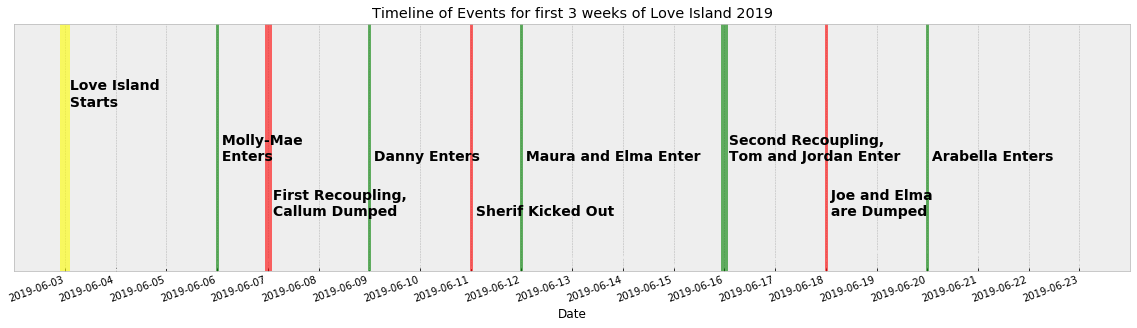

In [38]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)

sns.lineplot(x="date", y="score", color="#EEEEEE", data=agg_df[agg_df["islander"]=="anton"], ax=ax1)
plt.xticks(rotation=20, ha="right")
ax1.set(xticks=agg_df.date.unique(), yticks=[], xlabel="Date", ylabel="", ylim=(0, 3))
plt.title("Timeline of Events for first 3 weeks of Love Island 2019")

for key, item in storyline.items():
    ax1.axvline(item["date"], color=item["color"], linewidth=item["t"], alpha=0.6)
    ax1.text(item["date"], 2*item["h"]/3, key, fontsize=14, weight="bold")


Plotting the sentiment for tweets with an explicit referance to 

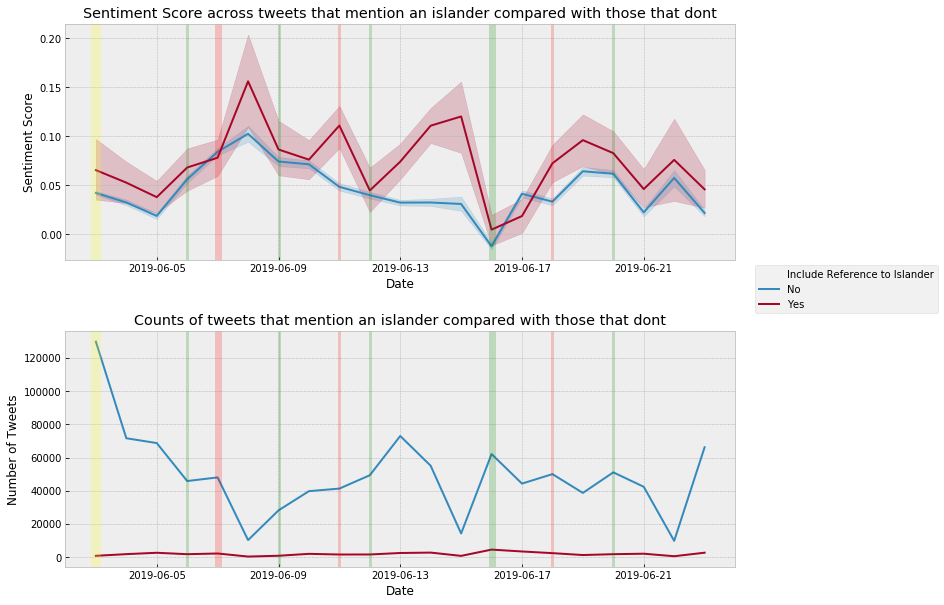

In [101]:
to_plot1 = get_counts(df, ["date", "inc_islander"]).rename(columns={"inc_islander": "Include Reference to Islander"})

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(211)
sns.lineplot("date", "score", "inc_islander", data=df, ax=ax1)
plt.legend().remove()
add_meta(ax1, "Sentiment Score", 
         "Sentiment Score across tweets that mention an islander compared with those that dont", False)
add_colours(ax1, storyline)

ax2 = fig.add_subplot(212, sharex=ax1)
sns.lineplot("date", "count", "Include Reference to Islander", data=to_plot1, ax=ax2)
add_meta(ax2, "Number of Tweets", 
         "Counts of tweets that mention an islander compared with those that dont", False)
plt.legend(bbox_to_anchor=(1.31,1.3))
add_colours(ax2, storyline)

plt.subplots_adjust(hspace=0.3);

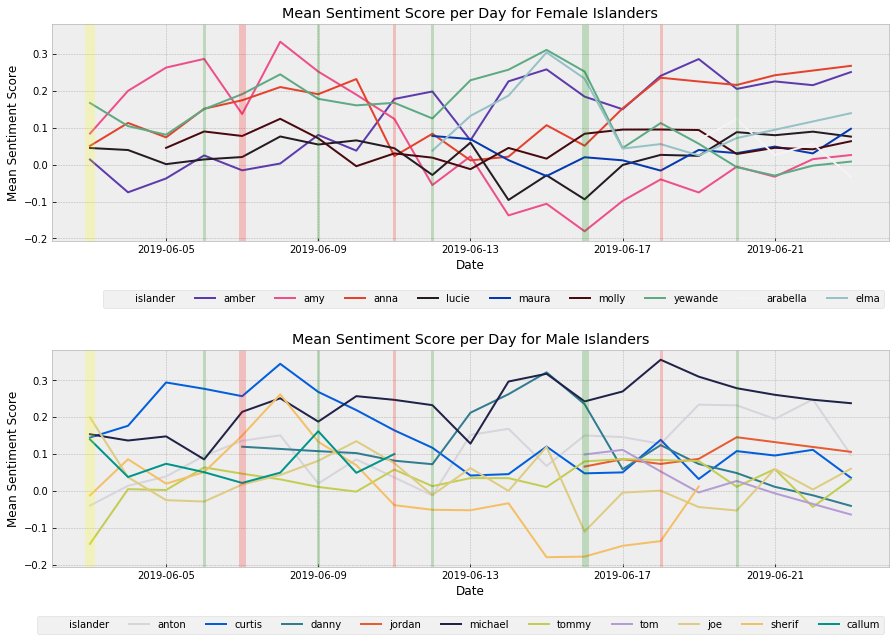

In [60]:
args = {"x": "date", "y": "score", "hue": "islander", "palette": PALETTE}
    
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(data=agg_df[agg_df["sex"]=="female"], ax=ax1, **args)
add_meta(ax1, "Mean Sentiment Score", "Mean Sentiment Score per Day for Female Islanders")
add_colours(ax1, storyline)

ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)
sns.lineplot(data=agg_df[agg_df["sex"]=="male"], ax=ax2, **args)
add_meta(ax2, "Mean Sentiment Score", "Mean Sentiment Score per Day for Male Islanders")
add_colours(ax2, storyline)

plt.subplots_adjust(hspace=0.5);

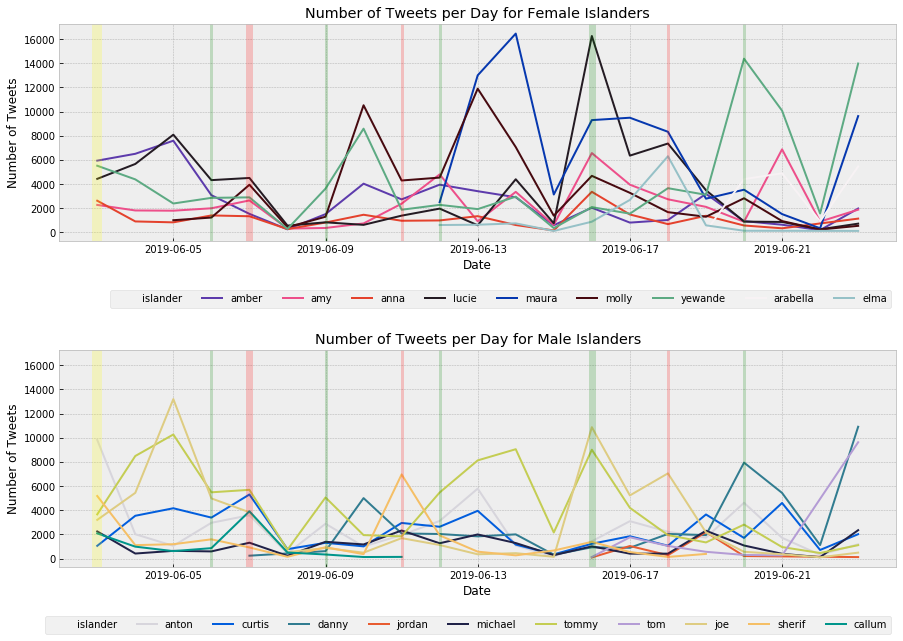

In [39]:
args = {"x": "date", "y": "n_tweets", "hue": "islander", "palette": PALETTE}
    
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
sns.lineplot(data=agg_df[agg_df["sex"]=="female"], ax=ax1, **args)
add_meta(ax1, "Number of Tweets", "Number of Tweets per Day for Female Islanders")
add_colours(ax1, storyline)

ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)
sns.lineplot(data=agg_df[agg_df["sex"]=="male"], ax=ax2, **args)
add_meta(ax2, "Number of Tweets", "Number of Tweets per Day for Male Islanders")
add_colours(ax2, storyline)

plt.subplots_adjust(hspace=0.5);

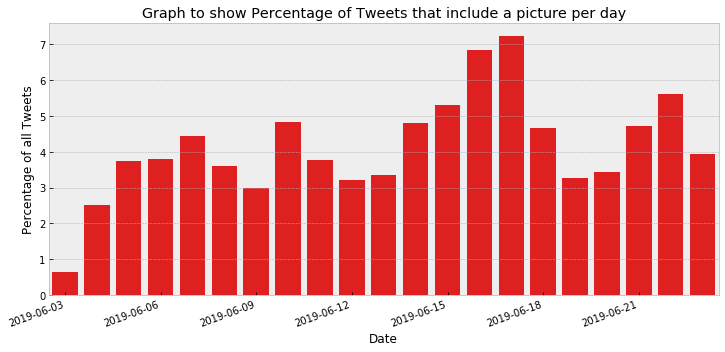

In [93]:
to_plot = get_counts(df, ["date", "inc_islander"]) 
to_plot["perc"] = to_plot.groupby("date")["count"].apply(lambda x: x*100 / x.sum())
to_plot = to_plot[to_plot["inc_islander"] == "Yes"]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

to_plot = get_counts(df, ["date", "inc_islander"]) 
to_plot["perc"] = to_plot.groupby("date")["count"].apply(lambda x: x*100 / x.sum())
to_plot = to_plot[to_plot["inc_islander"] == "Yes"]

sns.barplot("date", "perc", data=to_plot, color="Red", ax=ax1)

format_xticks(to_plot, ax1, 3)
plt.title("Graph to show Percentage of Tweets that include a picture per day")
plt.xlabel("Date")
plt.ylabel("Percentage of all Tweets");

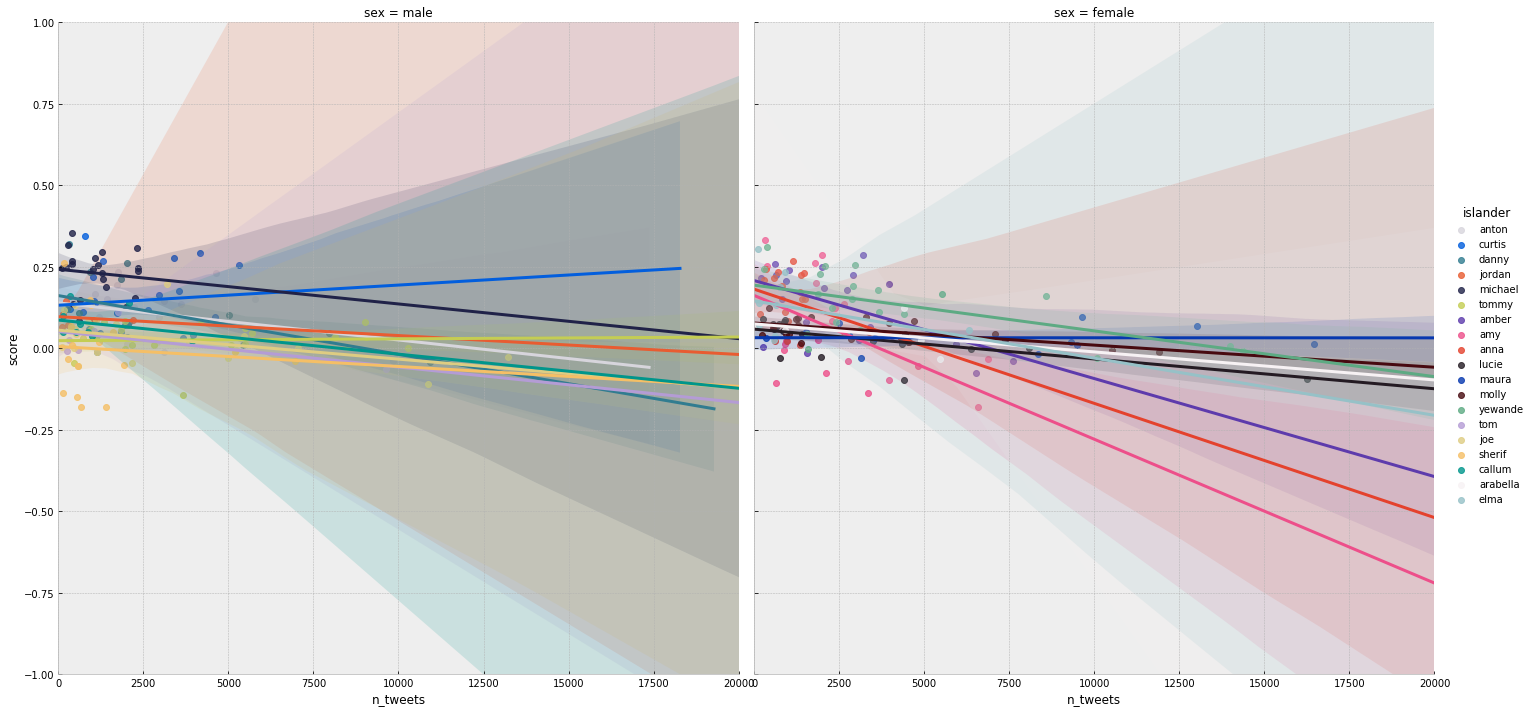

In [40]:
# Who is the most controversial?
# More tweets being correlated with a negative score = more convtroversial??

sns.lmplot("n_tweets", "score", hue="islander", data=agg_df, palette=PALETTE, height=10, col="sex")
plt.ylim(-1,1)
plt.xlim(0,20000);

In [41]:
def get_counts(df, group):
    return df.groupby(group)["url"].count().reset_index(name="count")

def order_days(df, col="dotw"):
    df[col] = pd.Categorical(
                df[col],
                categories=[
                    "Monday",
                    "Tuesday",
                    "Wednesday",
                    "Thursday",
                    "Friday",
                    "Saturday",
                    "Sunday",
                ],
                ordered=True,
            )
    return df

def get_daily_counts(df, col="date"):
    df = get_counts(df, [col])
    df["dotw"] = df[col].dt.strftime("%A")
    return order_days(df)

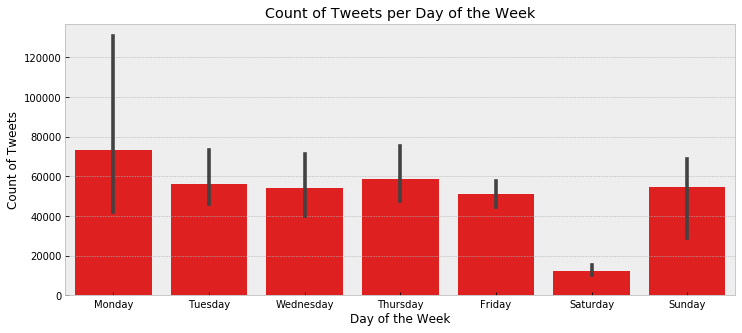

In [42]:
to_plot = get_daily_counts(df) 

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("dotw", "count", data=to_plot, color="Red", ax=ax1)

plt.xlabel("Day of the Week")
plt.ylabel("Count of Tweets")
plt.title("Count of Tweets per Day of the Week");

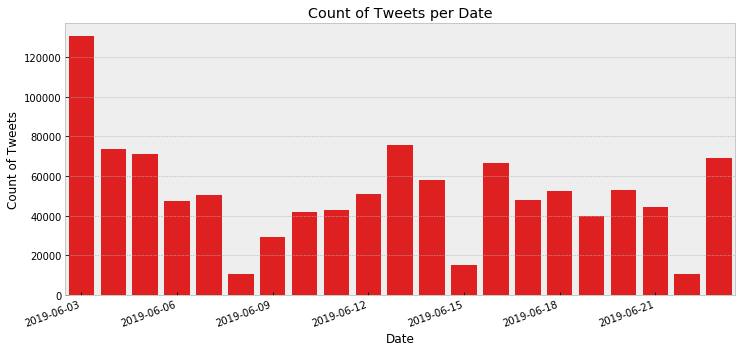

In [43]:
to_plot = get_counts(df, ["date"]) 

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "count", data=to_plot, color="Red", ax=ax1)

format_xticks(to_plot, ax1, 3)
plt.xlabel("Date")
plt.ylabel("Count of Tweets")
plt.title("Count of Tweets per Date");

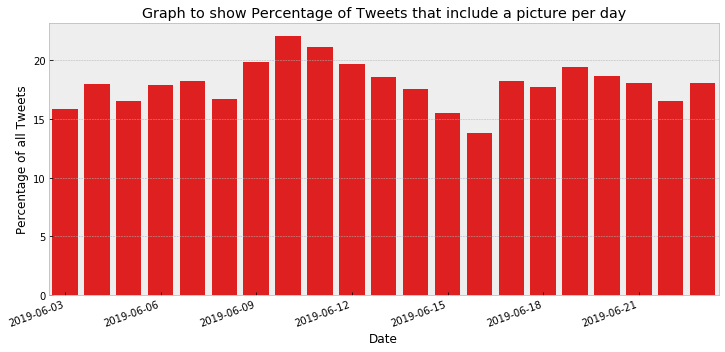

In [44]:
to_plot = get_counts(df, ["date", "pic"]) 
to_plot["perc"] = to_plot.groupby("date")["count"].apply(lambda x: x*100 / x.sum())
to_plot = to_plot[to_plot["pic"] == "yes"]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "perc", data=to_plot, color="Red", ax=ax1)

format_xticks(to_plot, ax1, 3)
plt.title("Graph to show Percentage of Tweets that include a picture per day")
plt.xlabel("Date")
plt.ylabel("Percentage of all Tweets");

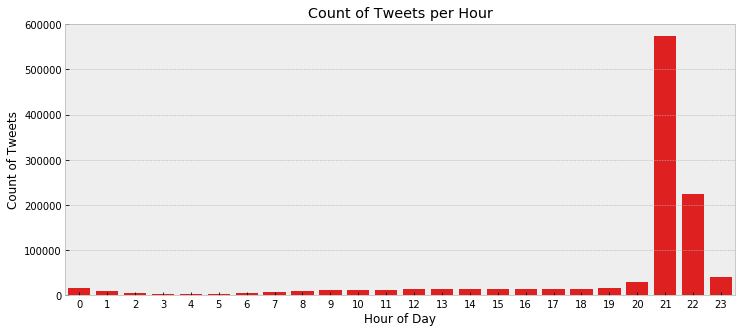

In [45]:
to_plot = get_counts(df, ["hour"]) 

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(111)
sns.barplot("hour", "count", data=to_plot, color="Red", ax=ax1)

plt.xlabel("Hour of Day")
plt.ylabel("Count of Tweets")
plt.title("Count of Tweets per Hour");

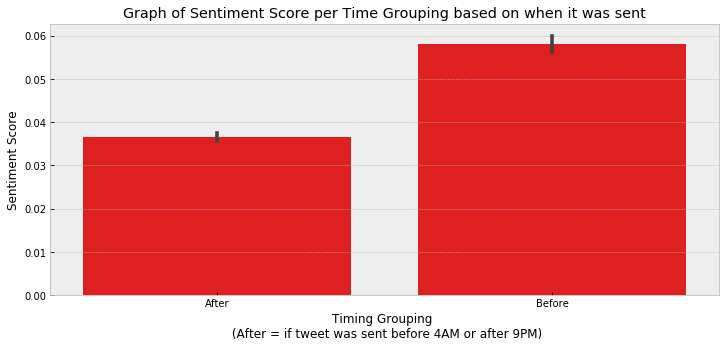

In [46]:
def group_hour(df, col="hour"):
    df["time_group"] = np.where((df[col] < 4) | (df[col] >= 21), "After", "Before")
    return df

df = group_hour(df)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("time_group", "score", data=df, color="Red", ax=ax1)

plt.xlabel("Timing Grouping \n (After = if tweet was sent before 4AM or after 9PM)")
plt.ylabel("Sentiment Score")
plt.title("Graph of Sentiment Score per Time Grouping based on when it was sent");

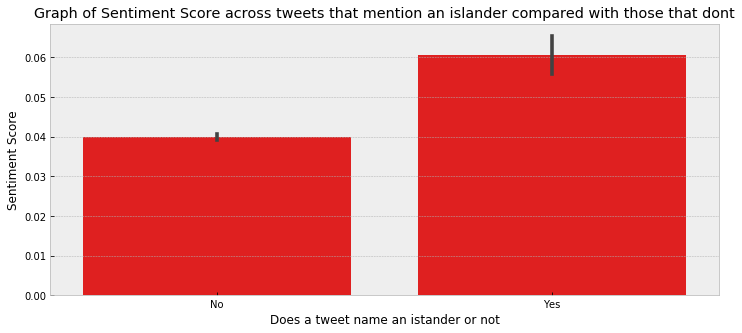

In [47]:
def inc_islander(df, col="islanders"):
    df["inc_islander"] = np.where(df[col].str.len() < 3, "No", "Yes")
    return df

df = inc_islander(df)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("inc_islander", "score", data=df, color="Red", ax=ax1)

plt.xlabel("Does a tweet name an istander or not")
plt.ylabel("Sentiment Score")
plt.title("Graph of Sentiment Score across tweets that mention an islander compared with those that dont");

In [50]:
def islander_agg_user(df, islander):
    """Aggregate various metrics per islander/date"""
    AGG_JS = {
        "favs": "sum",
        "retwe": "sum",
        "score": "mean",
        "url": "count",
        "weight_senti": "mean",
    }
    RN_JS = {islander: "islander", "url": "n_tweets"}
    df = df[df[islander] == islander]
    if len(df) > 0:
        return df.groupby(["user", islander])\
                 .agg(AGG_JS)\
                 .reset_index()\
                 .rename(columns=RN_JS)
    return pd.DataFrame()

def aggregate_users(df):
    """Loop over all islanders, aggregating metrics"""
    agg_df = pd.DataFrame()
    for islander in ISLANDERS:
        agg = islander_agg_user(df, islander)
        agg_df = agg_df.append(agg, sort=True)
    return agg_df.sort_values(by="n_tweets", ascending=False)\
                 .reset_index(drop=True)

In [52]:
fav_df = aggregate_users(df)
fav_df = add_cols(fav_df, islander_df)
fav_df.head()

,favs,islander,n_tweets,retwe,score,user,weight_senti,total_favs,total_retwe,col,sex,relevant,arrived,dumped,n_days
0,448,tommy,265,67,-0.175807,Daily_Star,-0.193935,118720,17755,#C4CD53,male,True,1,0,21
1,381,maura,214,60,-0.068523,Daily_Star,-0.078040,81534,12840,#0638AF,female,True,10,0,21
2,458,tommy,214,86,-0.332558,Daily_Express,-0.685491,98012,18404,#C4CD53,male,True,1,0,21
3,500,maura,201,134,-0.142155,MirrorTV,-0.583729,100500,26934,#0638AF,female,True,10,0,21
4,379,tommy,197,129,-0.240073,MirrorTV,-0.470412,74663,25413,#C4CD53,male,True,1,0,21


In [53]:
fav_df_pop = fav_df.sort_values(by="n_tweets", ascending=False).groupby(["islander"]).head(1)
fav_df_pop

,favs,islander,n_tweets,retwe,score,user,weight_senti,total_favs,total_retwe,col,sex,relevant,arrived,dumped,n_days
0,448,tommy,265,67,-0.175807,Daily_Star,-0.193935,118720,17755,#C4CD53,male,True,1,0,21
1,381,maura,214,60,-0.068523,Daily_Star,-0.078040,81534,12840,#0638AF,female,True,10,0,21
5,611,molly,179,124,-0.213490,MirrorTV,-1.589271,109369,22196,#470A10,female,True,4,0,21
6,332,lucie,178,116,-0.187166,MirrorTV,-0.401754,59096,20648,#241B23,female,True,1,0,21
9,553,sherif,162,252,-0.131244,Daily_Star,-0.496942,89586,40824,#F5BF66,male,False,1,9,8
11,371,amy,151,127,-0.034422,MirrorTV,-0.002897,56021,19177,#ED4F8A,female,True,1,0,21
12,6844,yewande,150,1871,0.040205,lovefromtey,15.880322,1026600,280650,#5DAA83,female,True,1,22,21
14,349,curtis,137,117,-0.069896,MirrorTV,-0.055187,47813,16029,#025EDD,male,True,1,0,21
17,580,danny,129,128,-0.203661,MirrorTV,-1.801316,74820,16512,#317C90,male,True,7,0,21
19,565,joe,117,45,0.150032,Kindredsoul9,0.406926,66105,5265,#DECC82,male,False,1,16,15


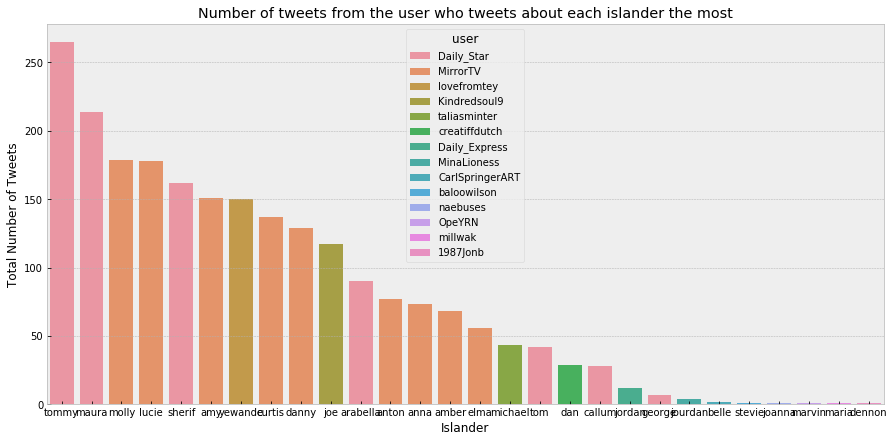

In [54]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(111)

sns.barplot("islander", "n_tweets", "user", data=fav_df_pop, dodge=False, ax=ax1)

plt.xlabel("Islander")
plt.ylabel("Total Number of Tweets")
plt.title("Number of tweets from the user who tweets about each islander the most");

In [55]:
fav_df_pop = fav_df.copy()

fav_df_pop = fav_df_pop[fav_df_pop["n_tweets"] > 20]
fav_df_pop["pos_neg"] = np.where(fav_df_pop["weight_senti"] < 0, "neg", "pos")
fav_df_pop["weight_senti"] = abs(fav_df_pop["weight_senti"])
fav_df_pop = fav_df_pop.sort_values(by="weight_senti", ascending=False).groupby(["islander", "pos_neg"]).head(1)
fav_df_pop

,favs,islander,n_tweets,retwe,score,user,weight_senti,total_favs,total_retwe,col,sex,relevant,arrived,dumped,n_days,pos_neg
1581,148754,michael,21,13829,0.199771,LoveIsland,2231.686567,3123834,290409,#202248,male,True,1,0,21,pos
924,70140,amy,26,7426,0.158912,IslandofLove32,1572.132254,1823640,193076,#ED4F8A,female,True,1,0,21,pos
864,85055,yewande,27,11239,0.067148,LoveIsIandUK,1283.335304,2296485,303453,#5DAA83,female,True,1,22,21,pos
504,57698,anton,32,2617,0.233219,JakeQuickenden,1082.462162,1846336,83744,#D7D5DC,male,True,1,0,21,pos
1378,104549,amber,22,9169,0.171223,LoveIsland,876.444459,2300078,201718,#5D3BAC,female,True,1,0,21,pos
603,120906,tommy,30,8884,0.195533,LoveIsland,723.060747,3627180,266520,#C4CD53,male,True,1,0,21,pos
848,36711,molly,27,3546,-0.007141,Beno_ldn,570.062215,991197,95742,#470A10,female,True,4,0,21,pos
357,42595,curtis,36,4204,0.155961,ItsJasminHere,518.910947,1533420,151344,#025EDD,male,True,1,0,21,pos
1488,108241,danny,22,10148,0.058564,LoveIsland,444.294055,2381302,223256,#317C90,male,True,7,0,21,neg
1196,38401,lucie,24,1898,0.166154,JakeQuickenden,256.818708,921624,45552,#241B23,female,True,1,0,21,pos


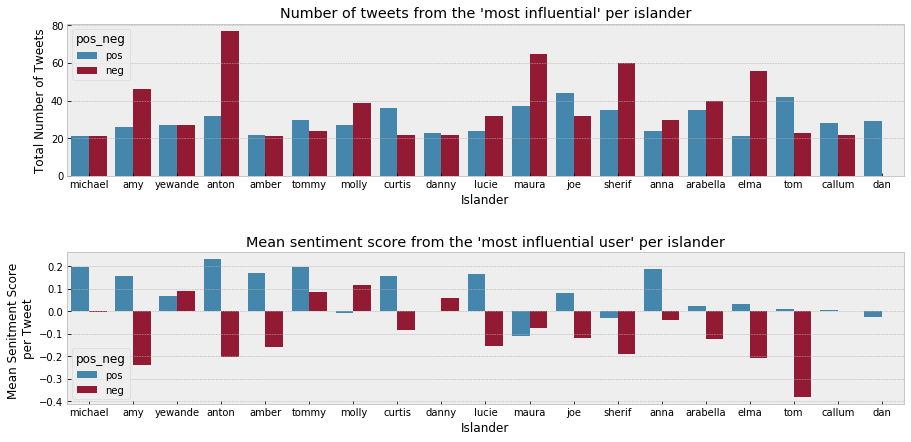

In [56]:
fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(211)
sns.barplot("islander", "n_tweets", "pos_neg", data=fav_df_pop, dodge=True, ax=ax1)
ax1.set_xlabel("Islander")
ax1.set_ylabel("Total Number of Tweets")
ax1.set_title("Number of tweets from the 'most influential' per islander")

ax2 = fig.add_subplot(212)
sns.barplot("islander", "score", "pos_neg", data=fav_df_pop, dodge=True, ax=ax2)
ax2.set_xlabel("Islander")
ax2.set_ylabel("Mean Senitment Score \nper Tweet")
ax2.set_title("Mean sentiment score from the 'most influential user' per islander")

plt.subplots_adjust(hspace=0.5);

In [57]:
favs = df.groupby(["user", "date"])\
         .agg({"favs":"sum", "url": "count"})\
         .reset_index()\
         .rename(columns={"url": "n_tweets"})

favs["rate"] = favs["favs"] / favs["n_tweets"]
days = favs.groupby("user").size().reset_index(name="n_days")
favs = favs.merge(days, on="user", how="left")
favs.head()

,user,date,favs,n_tweets,rate,n_days
0,00000TomCooper,2019-06-23,8,1,8.0,1
1,000_wilson,2019-06-04,3,1,3.0,1
2,001Randomess95,2019-06-03,2,2,1.0,6
3,001Randomess95,2019-06-06,6,1,6.0,6
4,001Randomess95,2019-06-11,0,1,0.0,6


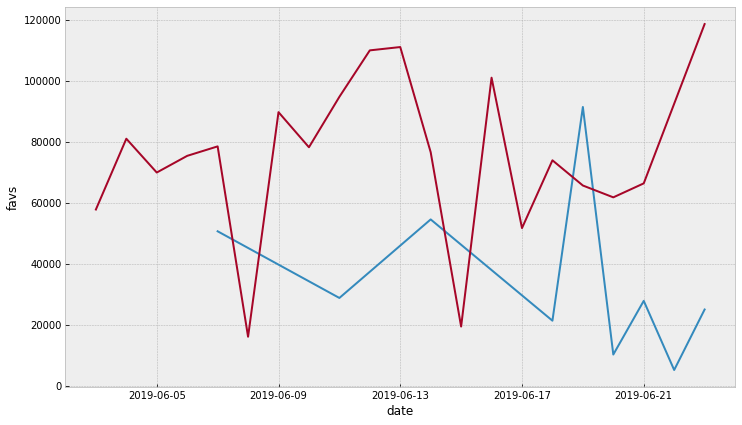

In [58]:
favs_t = favs[(favs["rate"] > 2000) & (favs["n_days"] > 20)]
len(favs)
# favs.sort_values("rate", ascending=False).head()


fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
sns.lineplot("date", "favs", "user", data=favs_t, ax=ax1)
plt.legend().remove()

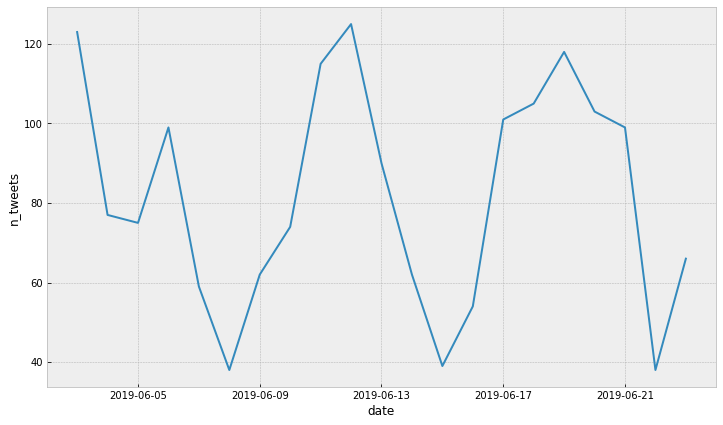

In [59]:
favs_t = favs.sort_values("n_tweets", ascending=False).groupby("date").head(1)

fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
sns.lineplot("date", "n_tweets", data=favs_t, ax=ax1)